In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts

colors = ["red", "green", "blue", "orange", "purple", "olive", "brown", "lavender", "aqua", "salmon", "turquoise", "indigo"]

### Pre-process the data

The csv file imported has a extra column for "Neighborhood" comparing to the original. 

After visualizing the data using histogram for the price of each item, I found some anomalies data: in Sara Merner's response for Sainbury's, Banana Product 3: 1 kg banana = 75 euro. Same for Eggs: Responses by Bella at EDEKA: 1 egg cost 3 euro and 1 egg cost 2.5 euro. These data seems to be too far off. As we have decent amount of data, I will delete these (potentially) wrong input.

In [0]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRgYwMhPfaQ6Sh8EEwPbFq5KKmHD731DirxREegeeStb6Q9gbbzBVdOYPmAvHeHGX0WBQJZf5qSDHwW/pub?gid=183047588&single=true&output=csv")

In [0]:
# the reason I added XX in order to make every element has 8 characters!
items = ["ApplesXX", "BananasX", "Tomatoes", "Potatoes", "FlourXXX",
          "RiceXXXX", "MilkXXXX", "ButterXX", "EggsXXXX", "ChickenX"]

# Change the name of the columns: 
for i in range(6, 66):
  if i%6 == 0:
    # the name of the items
    current_item = items[i//6-1]
  # [7:] is to replace the work product with the item name
  data.iloc[0][i] = current_item + data.iloc[0][i][7:]
# change the column name
data.columns = data.iloc[0]
# drop the 2 empty rows
data = data.drop([0,1]).reset_index() 

In [0]:
# change the data into number
for i in range(7,67):
  data[data.columns[i]] = data[data.columns[i]].apply(pd.to_numeric)

In [0]:
# calculate the average price: euro/kg
for i in range(7, 67, 2):
  item = data.columns[i][:11] + "average"
  data[item] = data[data.columns[i+1]]/data[data.columns[i]]

# for eggs, I consider 1 egg = 50g -> 1kg = 20 eggs -> multiply 20 for the price. 
data["EggsXXXX 1 average"] = data["EggsXXXX 1 average"]*20 
data["EggsXXXX 2 average"] = data["EggsXXXX 2 average"]*20 
data["EggsXXXX 3 average"] = data["EggsXXXX 3 average"]*20 

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
data["Grocery store"].unique()

array(['EDEKA', 'REWE', 'ALDI', 'Tesco Express',
       'Waitrose & Partners Islington', 'Lidl', 'Waitrose & Partners ',
       "Sainsbury's ", 'Waitrose & Partners', 'Sainsbury', 'Tesco',
       'Safeway', 'Waitrose', "SAINSBURY'S", 'Sainsbury’s ', 'Tesco ',
       'Lotte Mart'], dtype=object)

In [0]:
# change the name of the stores for unification
data["Grocery store"] = data["Grocery store"].map({'ALDI': 'ALDI', 'REWE': 'REWE', 
                                                   'Lidl': 'LIDL', 'Tesco Express': "TESCO",
                                                   'EDEKA': 'EDEKA', 'Waitrose & Partners': 'WAITROSE',
                                                   'Safeway': 'SAFEWAY', 'Waitrose': 'WAITROSE', 
                                                   'Lotte Mart': "LOTTE", 'Tesco': 'TESCO',
                                                   "SAINSBURY'S": 'SAINBURY', 'Waitrose & Partners ': "WAITROSE",
                                                   "Sainsbury's ": 'SAINBURY', 'Sainsbury': 'SAINBURY', 
                                                   'Sainsbury’s ': 'SAINBURY', 'Waitrose & Partners Islington': "WAITROSE",
                                                   'Tesco ': "TESCO"})

In [0]:
# merging the data: 1st factor normalization (similar to concept in SQL)
# meaning that only 1 column for all the item (not 30 columns like before)
f_data = pd.DataFrame(columns = ["Grocery store", "Location", "Item", "Price"])

# iterate throught the items
for item in items:
  # iterate through the 3 average values + dropna
  for k in [" 1 average", " 2 average", " 3 average"]:
    cur_data = pd.DataFrame.copy(data[["Grocery store", "Location", item + k]].dropna(), deep = True)
    cur_data = cur_data.rename(columns={item + k: "Price"})
    cur_data["Item"] = item
    f_data = pd.concat([f_data, cur_data], ignore_index=False, sort=False)

In [0]:
# check if all the data is not nan. 
# it should return 0 for all values
f_data.isnull().sum()

Grocery store    0
Location         0
Item             0
Price            0
dtype: int64

In [0]:
f_data.head()

,Grocery store,Location,Item,Price
0,EDEKA,Kreuzberg,ApplesXX,2.490
1,REWE,Schöneberg,ApplesXX,1.490
2,REWE,Kreuzberg,ApplesXX,2.490
3,REWE,Alt-Treptow,ApplesXX,1.995
4,EDEKA,Friedrichshain,ApplesXX,3.050


### Model explanation

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_price;  
    int<lower=1> num_product;
    real<lower=0> price[num_price];  
    vector<lower=0>[num_product] product[num_price];  
    int<lower=1> num_location; 
    vector<lower=0>[num_location] location[num_price];   
    int<lower=1> num_store; 
    vector<lower=0>[num_store] store[num_price];   
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    row_vector<lower=0>[num_location] p_location;
    row_vector<lower=0>[num_store] p_store;  
    row_vector<lower=0>[num_product] base;
    real<lower = 0> std;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    base ~ cauchy(0,1);

    std ~ cauchy(0,1);

    p_location ~ lognormal(0,0.25);

    p_store ~ lognormal(0, 0.25);
    
    for(i in 1:num_price) {
        price[i] ~ normal((base*product[i])* (p_location*location[i]) * (p_store*store[i]) , std);
    }
}

"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb264247cbead66d45d0bac26dfb2de9 NOW.


In [0]:
def visualization(a_data, posterior_samples):
  ##############################################################################
  # Price
  base_price = pd.DataFrame(columns= ["Item", "Mean", "2.5% percentile", "97.5% percentile", "Standard Deviation"])
  # Plot the Location
  plt.figure(figsize=(12, 6))
  for i in range(len(posterior_samples['base'][0])):
    plt.hist(np.array(posterior_samples['base']).T[i], alpha = 0.5, label = pd.get_dummies(a_data["Item"]).columns[i], color = colors[i], density= True)
    plt.axvline(np.mean(posterior_samples['base'].T[i]), linestyle='dashed', linewidth=1, label = pd.get_dummies(a_data["Item"]).columns[i], color = colors[i])
    base_price.loc[i] = [pd.get_dummies(a_data["Item"]).columns[i]] + np.quantile(np.array(posterior_samples['base'].T[i]), [0.5, 0.025, 0.975]).tolist() \
    + [np.std(np.array(posterior_samples['base'].T[i]))]
  plt.legend(loc='upper right')
  plt.title("Histogram of base price distribution of different products")
  plt.xlabel("Base Price (euro)")
  plt.show()

  table_1 = base_price
  display(table_1.sort_values("Mean").reset_index().transpose())

  ##############################################################################
  # Location 
  location_mul = pd.DataFrame(columns= ["Neighborhood", "Mean", "2.5% percentile", "97.5% percentile", "Standard Deviation"])
  # Plot the Location
  plt.figure(figsize=(12, 6))
  for i in range(len(posterior_samples['p_location'][0])):
    plt.hist(np.array(posterior_samples['p_location']).T[i], alpha = 0.5, label = pd.get_dummies(a_data["Location"]).columns[i], color = colors[i], density= True)
    plt.axvline(np.mean(posterior_samples['p_location'].T[i]), linestyle='dashed', linewidth=1, label = pd.get_dummies(a_data["Location"]).columns[i], color = colors[i])
    location_mul.loc[i] = [pd.get_dummies(a_data["Location"]).columns[i]] + np.quantile(np.array(posterior_samples['p_location'].T[i]), [0.5, 0.025, 0.975]).tolist() \
    + [np.std(np.array(posterior_samples['p_location'].T[i]))]
  plt.legend(loc='upper right')
  plt.title("Histogram of location multiplier distribution of different locations")
  plt.xlabel("Location multiplier")
  plt.show()

  table_2 = location_mul
  display(table_2.sort_values("Mean").reset_index().transpose())


  #############################################################################
  # Store brands
  store_mul = pd.DataFrame(columns= ["Store", "Mean", "2.5% percentile", "97.5% percentile", "Standard Deviation"])
  # Plot the Store
  plt.figure(figsize=(12, 6))
  for i in range(len(posterior_samples['p_store'][0])):
    plt.hist(np.array(posterior_samples['p_store']).T[i], alpha = 0.4, label = pd.get_dummies(a_data["Grocery store"]).columns[i], color = colors[i], density= True)
    plt.axvline(np.mean(posterior_samples['p_store'].T[i]), linestyle='dashed', linewidth=1, label = pd.get_dummies(a_data["Grocery store"]).columns[i], color = colors[i])
    store_mul.loc[i] = [pd.get_dummies(a_data["Grocery store"]).columns[i]] + np.quantile(np.array(posterior_samples['p_store'].T[i]), [0.5, 0.025, 0.975]).tolist() \
    + [np.std(np.array(posterior_samples['p_store'].T[i]))]
  plt.legend(loc='upper right')
  plt.title("Histogram of store multiplier distribution of different stores")
  plt.xlabel("Store multiplier")
  plt.show()

  table_3 = store_mul 
  display(table_3.sort_values("Mean").reset_index().transpose())


  #############################################################################
  plt.figure(figsize=(12, 6))
  for i in range(len(posterior_samples['base'][0])):
    plt.plot(sts.uniform.rvs(loc=2*i-0.2, scale=0.4, size=len(np.array(posterior_samples['base']).T[i])), \
             np.array(posterior_samples['base']).T[i], ',', alpha=0.5)
  plt.xticks(np.array(list(range(len(posterior_samples['base'][0]))))*2, pd.get_dummies(a_data["Item"]).columns)
  plt.title("Base price distribution of items")
  plt.ylabel("(Euro)")
  plt.show()


  #############################################################################
  plt.figure(figsize=(18, 9))
  for i in range(len(posterior_samples['p_location'][0])):
    plt.plot(sts.uniform.rvs(loc=2*i-0.2, scale=0.4, size=len(np.array(posterior_samples['p_location']).T[i])), \
             np.array(posterior_samples['p_location']).T[i], ',', alpha=0.5)
  plt.xticks(np.array(list(range(len(posterior_samples['p_location'][0]))))*2, pd.get_dummies(a_data["Location"]).columns)
  plt.title("Location multiplier distribution of different locations")
  plt.show()


  #############################################################################
  plt.figure(figsize=(12, 6))
  for i in range(len(posterior_samples['p_store'][0])):
    plt.plot(sts.uniform.rvs(loc=2*i-0.2, scale=0.4, size=len(np.array(posterior_samples['p_store']).T[i])), \
             np.array(posterior_samples['p_store']).T[i], ',', alpha=0.5)
  plt.xticks(np.array(list(range(len(posterior_samples['p_store'][0]))))*2, pd.get_dummies(a_data["Grocery store"]).columns)
  plt.title("Location multiplier distribution of different stores")
  plt.show()
  return table_1, table_2, table_3

In [0]:
def result_ttest(p_value, z_score, first_sample, second_sample):
  if p_value > 0.05: 
    print("Cannot reject the null hypothesis that 2 independent samples,", \
          first_sample, "and", second_sample, ", have identical average (expected) values")
  else: 
    if z_score < 0:
      print(first_sample, "is significantly cheaper than", second_sample)
    else: 
      print(first_sample, "is significantly more expensive than", second_sample)

def t_test(posterior_samples):
  print("T test for pairwise location")
  for i in range(len(posterior_samples['p_location'][0])):
    for j in range(i + 1, len(posterior_samples['p_location'][0])):
      z_score, p_value = sts.ttest_ind(posterior_samples['p_location'].T[i], posterior_samples['p_location'].T[j])
      result_ttest(p_value, z_score, pd.get_dummies(a_data["Location"]).columns[i], pd.get_dummies(a_data["Location"]).columns[j])
  print("######################################################################")
  print("")
  print("T test for pairwise store")
  for i in range(len(posterior_samples['p_store'][0])):
    for j in range(i + 1, len(posterior_samples['p_store'][0])):
      z_score, p_value = sts.ttest_ind(posterior_samples['p_store'].T[i], posterior_samples['p_store'].T[j])
      result_ttest(p_value, z_score, pd.get_dummies(a_data["Grocery store"]).columns[i], pd.get_dummies(a_data["Grocery store"]).columns[j])

In [0]:
a_data = f_data

stan_data = {
    "num_price": len(list(a_data["Price"])),
    "price": list(a_data["Price"]),
    "num_product": len(np.array(pd.get_dummies(a_data["Item"])).tolist()[0]), 
    "product": np.array(pd.get_dummies(a_data["Item"])).tolist(),
    "num_store": len(np.array(pd.get_dummies(a_data["Grocery store"])).tolist()[0]),
    "store": np.array(pd.get_dummies(a_data["Grocery store"])).tolist(),
    "num_location": len(np.array(pd.get_dummies(a_data["Location"])).tolist()[0]),
    "location": np.array(pd.get_dummies(a_data["Location"])).tolist()
    }
stan_results = stan_model.sampling(data=stan_data)
posterior_samples = stan_results.extract()

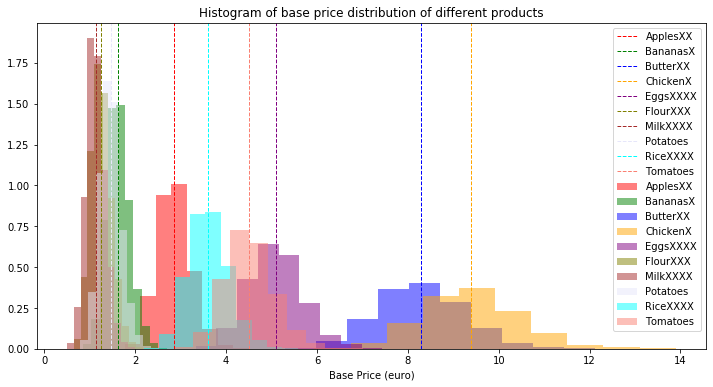

,0,1,2,3,4,5,6,7,8,9
index,6,5,7,1,0,8,9,4,2,3
Item,MilkXXXX,FlourXXX,Potatoes,BananasX,ApplesXX,RiceXXXX,Tomatoes,EggsXXXX,ButterXX,ChickenX
Mean,1.10742,1.23613,1.44356,1.60772,2.83698,3.58771,4.47492,5.07609,8.26519,9.34401
2.5% percentile,0.753524,0.855642,1.02805,1.16483,2.20494,2.8258,3.53198,4.02254,6.54183,7.43037
97.5% percentile,1.56219,1.72726,1.95692,2.1681,3.61453,4.52146,5.63206,6.34139,10.2672,11.5855
Standard Deviation,0.2056,0.222945,0.236528,0.254374,0.361402,0.440645,0.531229,0.593532,0.946695,1.0676


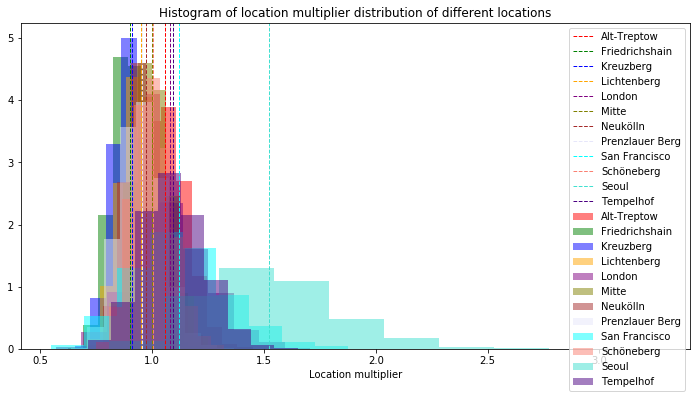

,0,1,2,3,4,5,6,7,8,9,10,11
index,1,2,3,7,6,5,9,0,4,11,8,10
Neighborhood,Friedrichshain,Kreuzberg,Lichtenberg,Prenzlauer Berg,Neukölln,Mitte,Schöneberg,Alt-Treptow,London,Tempelhof,San Francisco,Seoul
Mean,0.89587,0.904354,0.946851,0.948251,0.967589,0.995939,0.999205,1.05466,1.06514,1.08486,1.1105,1.49895
2.5% percentile,0.757742,0.765138,0.786589,0.780191,0.82636,0.850495,0.844559,0.883726,0.777699,0.842086,0.752132,1.03536
97.5% percentile,1.05766,1.07543,1.1312,1.14564,1.14861,1.16657,1.18667,1.2546,1.43794,1.37229,1.57618,2.16049
Standard Deviation,0.0772469,0.0797291,0.0879115,0.0934878,0.0836501,0.0825697,0.0882249,0.0951849,0.166534,0.136824,0.210721,0.29316


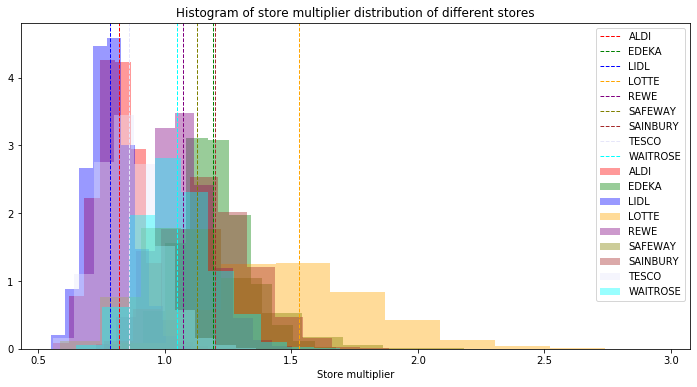

,0,1,2,3,4,5,6,7,8
index,2,0,7,8,4,5,1,6,3
Store,LIDL,ALDI,TESCO,WAITROSE,REWE,SAFEWAY,EDEKA,SAINBURY,LOTTE
Mean,0.78024,0.816804,0.850657,1.0395,1.06337,1.10148,1.1844,1.18709,1.50391
2.5% percentile,0.63343,0.659837,0.658503,0.806852,0.864636,0.759114,0.963734,0.916512,1.02864
97.5% percentile,0.965232,1.0032,1.10032,1.34069,1.3161,1.61101,1.454,1.53411,2.17874
Standard Deviation,0.0842022,0.0881243,0.113402,0.139184,0.113158,0.219478,0.123905,0.158475,0.297489


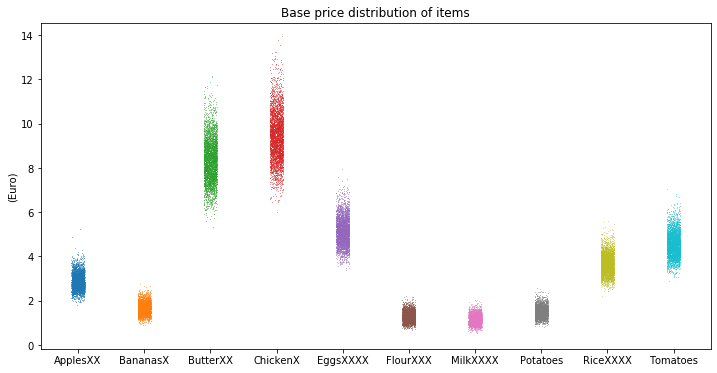

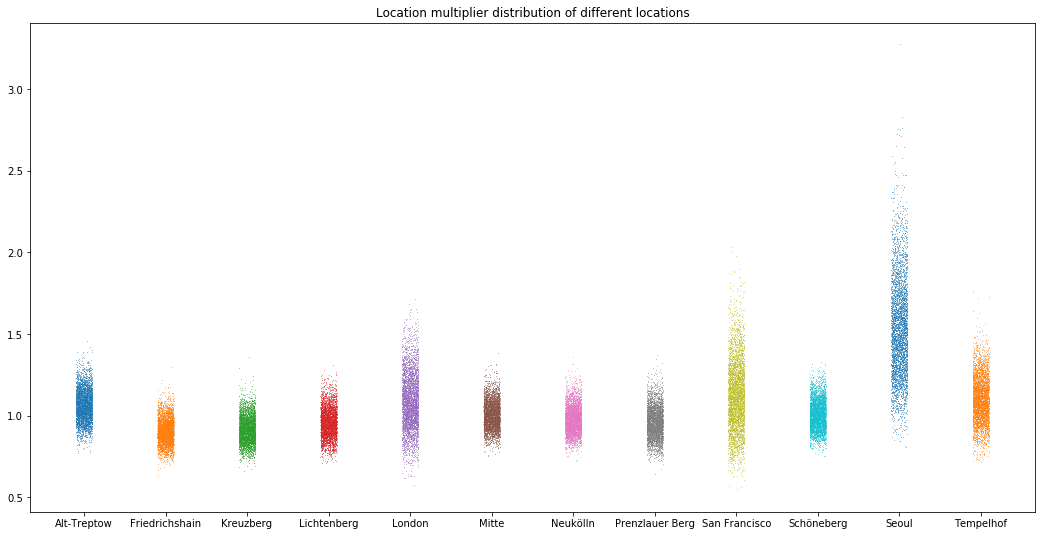

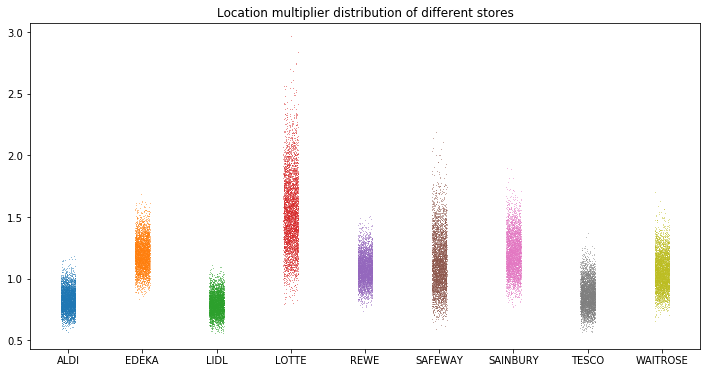

In [0]:
base_price, location_mul, store_mul = visualization(a_data, posterior_samples)

In [0]:
t_test(posterior_samples)

T test for pairwise location
Alt-Treptow is significantly more expensive than Friedrichshain
Alt-Treptow is significantly more expensive than Kreuzberg
Alt-Treptow is significantly more expensive than Lichtenberg
Alt-Treptow is significantly cheaper than London
Alt-Treptow is significantly more expensive than Mitte
Alt-Treptow is significantly more expensive than Neukölln
Alt-Treptow is significantly more expensive than Prenzlauer Berg
Alt-Treptow is significantly cheaper than San Francisco
Alt-Treptow is significantly more expensive than Schöneberg
Alt-Treptow is significantly cheaper than Seoul
Alt-Treptow is significantly cheaper than Tempelhof
Friedrichshain is significantly cheaper than Kreuzberg
Friedrichshain is significantly cheaper than Lichtenberg
Friedrichshain is significantly cheaper than London
Friedrichshain is significantly cheaper than Mitte
Friedrichshain is significantly cheaper than Neukölln
Friedrichshain is significantly cheaper than Prenzlauer Berg
Friedrichshain

In [0]:
location_mul["Rent (1000 euro)"] = np.array([2524, 3604,3604,2331,11592,3921,2362,5720,11635,2578,11266,2578])/1000
# For Seoul: https://www.numbeo.com/property-investment/in/Seoul
# For Berlin: https://www.berlinhyp.de/bhyp/en/medias/sys_master/pdf/h68/hd1/8812673892382.pdf (page 12)
### and https://guthmann.estate/en/market-report/berlin/prenzlauer-berg/
# For London = 1/2(city of london + stratford) : the location of Minerva res hall is between these 2 areas
# For SF: https://www.zillow.com/san-francisco-ca/home-values/

Multiplier = 0.026221936184307206 * Rent +  0.9001203705817971
r_square value: 0.39550691310466246


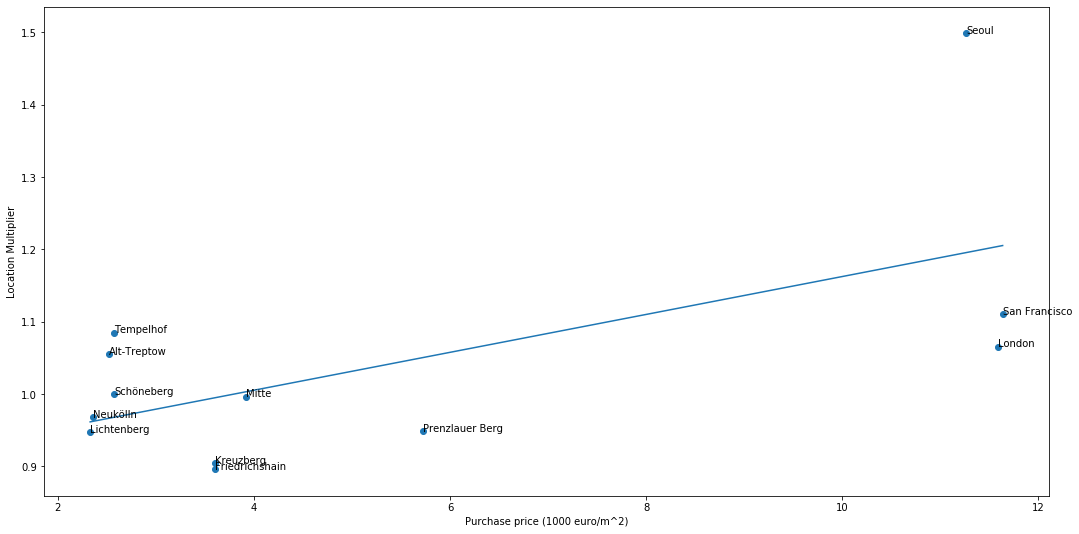

In [0]:
slope, intercept, r_value, _, _ = sts.linregress(np.array(location_mul["Rent (1000 euro)"]), np.array(location_mul["Mean"]))
print("Multiplier =", slope, "* Rent + ", intercept)
print("r_square value:", r_value**2)
plt.figure(figsize=(18, 9))
plt.scatter(location_mul["Rent (1000 euro)"], np.array(location_mul["Mean"]))
plt.plot([min(location_mul["Rent (1000 euro)"]), max(location_mul["Rent (1000 euro)"])], [slope*min(location_mul["Rent (1000 euro)"])+intercept,slope*max(location_mul["Rent (1000 euro)"])+intercept])
for i in range(len(pd.get_dummies(a_data["Location"]).columns)):
  plt.annotate(pd.get_dummies(a_data["Location"]).columns[i], (location_mul["Rent (1000 euro)"][i], np.array(location_mul["Mean"])[i]))
plt.xlabel("Purchase price (1000 euro/m^2)")
plt.ylabel("Location Multiplier")
plt.show()

### Stretch goal

In [0]:
maps = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQ2_fCiak2gtuQEfgUi32PK9JOJo4XQKFhYRjH5bN4hlO_RuyZLKNdHjhhu9kOFgSgk7vpiW6fGBlJ7/pub?gid=0&single=true&output=csv")

In [0]:
maps["harmonic mean"] = 0
for i in range(len(maps)):
  maps["harmonic mean"].iloc[i] = sts.hmean(maps[maps.columns[1:13]].iloc[i],axis = 0) 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
for i in maps.columns[1:13]:
  maps[i] = 1/maps[i]*maps["harmonic mean"]/12

In [0]:
B_data = f_data[f_data["Location"].isin(maps.columns[1:13])]

In [0]:
maps.columns[1:13]

Index(['Alt-Treptow', 'Friedrichshain', 'Kreuzberg', 'Lichtenberg', 'Mitte',
       'Neukölln', 'Prenzlauer Berg', 'Schöneberg', 'Tempelhof', 'London',
       'Seoul', 'San Francisco'],
      dtype='object')

In [0]:
B_data["Location"].unique()

array(['Kreuzberg', 'Schöneberg', 'Alt-Treptow', 'Friedrichshain',
       'Lichtenberg', 'London', 'Mitte', 'Prenzlauer Berg', 'Neukölln',
       'San Francisco', 'Tempelhof', 'Seoul'], dtype=object)

In [0]:
maps

,Unnamed: 0,Alt-Treptow,Friedrichshain,Kreuzberg,Lichtenberg,Mitte,Neukölln,Prenzlauer Berg,Schöneberg,Tempelhof,London,Seoul,San Francisco,harmonic mean
0,Alt-Treptow,0.420508,0.131409,0.107823,0.063713,0.045216,0.058404,0.062762,0.051282,0.058404,0.000381,0.000052,0.000046,5.046101
1,Friedrichshain,0.124893,0.399657,0.090831,0.086882,0.052586,0.039570,0.114188,0.043918,0.047019,0.000362,0.000049,0.000044,4.795889
2,Kreuzberg,0.100805,0.089350,0.393139,0.046252,0.061428,0.047944,0.075604,0.091428,0.093604,0.000356,0.000048,0.000043,4.717665
3,Lichtenberg,0.076557,0.109842,0.059444,0.505274,0.046785,0.036614,0.085640,0.040101,0.039169,0.000458,0.000062,0.000056,6.063287
4,Mitte,0.052712,0.064503,0.076597,0.045391,0.490220,0.034523,0.096121,0.081703,0.057673,0.000444,0.000060,0.000054,5.882636
5,Neukölln,0.075478,0.053806,0.066273,0.039380,0.038271,0.543441,0.042127,0.054344,0.086261,0.000492,0.000067,0.000060,6.521297
6,Prenzlauer Berg,0.064771,0.123989,0.083454,0.073553,0.085091,0.033641,0.433963,0.052285,0.048760,0.000393,0.000053,0.000048,5.207553
7,Schöneberg,0.055374,0.049897,0.105597,0.036037,0.075678,0.045407,0.054707,0.454066,0.122721,0.000411,0.000056,0.000050,5.448794
8,Tempelhof,0.062218,0.052702,0.106659,0.034726,0.052702,0.071106,0.050334,0.121073,0.447969,0.000406,0.000055,0.000049,5.375630
9,London,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.000898,0.991688,0.000112,0.000115,11.900261


In [0]:
b_data = B_data

location_coor = pd.DataFrame(columns = maps.columns[1:13])
for i in range(len(b_data)):
  location_coor.loc[i] = list(maps[maps["Unnamed: 0"] == b_data.iloc[i][1]].iloc[0])[1:13]

stan_data_2 = {
    "num_price": len(list(b_data["Price"])),
    "price": list(b_data["Price"]),
    "num_product": len(np.array(pd.get_dummies(b_data["Item"])).tolist()[0]), 
    "product": np.array(pd.get_dummies(b_data["Item"])).tolist(),
    "num_store": len(np.array(pd.get_dummies(b_data["Grocery store"])).tolist()[0]),
    "store": np.array(pd.get_dummies(b_data["Grocery store"])).tolist(),
    "num_location": len(np.array(location_coor).tolist()[0]),
    "location": np.array(location_coor).tolist()
    }

stan_results_2 = stan_model.sampling(data=stan_data_2)
posterior_samples_2 = stan_results_2.extract()



In [0]:
b_data["Location"].unique()

array(['Kreuzberg', 'Schöneberg', 'Alt-Treptow', 'Friedrichshain',
       'Lichtenberg', 'London', 'Mitte', 'Prenzlauer Berg', 'Neukölln',
       'San Francisco', 'Tempelhof', 'Seoul'], dtype=object)

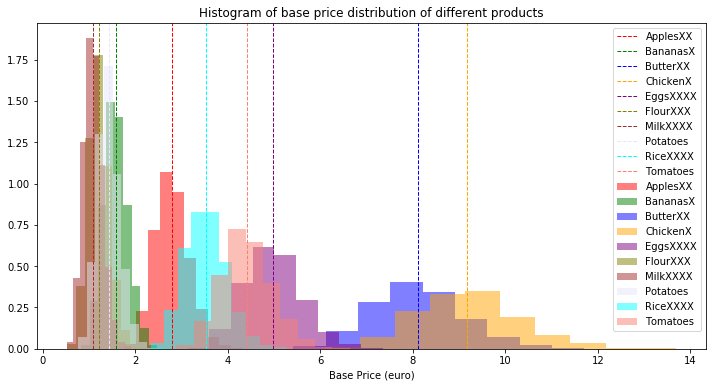

,0,1,2,3,4,5,6,7,8,9
index,6,5,7,1,0,8,9,4,2,3
Item,MilkXXXX,FlourXXX,Potatoes,BananasX,ApplesXX,RiceXXXX,Tomatoes,EggsXXXX,ButterXX,ChickenX
Mean,1.08281,1.20776,1.41058,1.5697,2.76429,3.50899,4.3723,4.94629,8.0672,9.13917
2.5% percentile,0.733518,0.812606,0.996121,1.12434,2.15524,2.73623,3.44958,3.89405,6.36077,7.23311
97.5% percentile,1.53237,1.70382,1.94421,2.12949,3.56556,4.46613,5.55334,6.29645,10.1593,11.5026
Standard Deviation,0.202787,0.224527,0.239796,0.254799,0.364784,0.444844,0.546057,0.6117,0.970357,1.09757


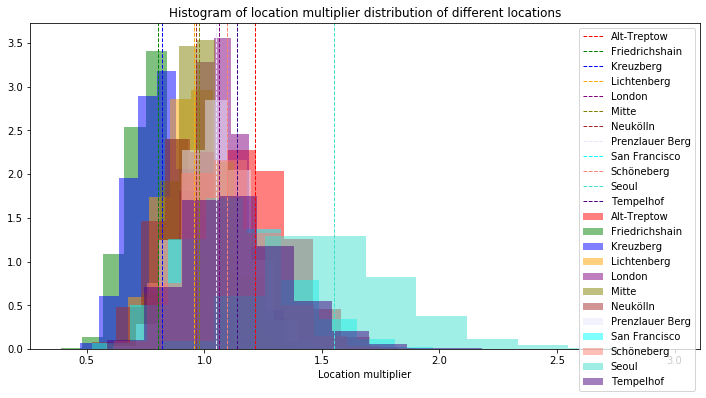

,0,1,2,3,4,5,6,7,8,9,10,11
index,1,2,6,3,5,7,4,9,11,8,0,10
Neighborhood,Friedrichshain,Kreuzberg,Neukölln,Lichtenberg,Mitte,Prenzlauer Berg,London,Schöneberg,Tempelhof,San Francisco,Alt-Treptow,Seoul
Mean,0.797218,0.814448,0.953476,0.954583,0.975092,1.046,1.05855,1.08095,1.12069,1.12506,1.20842,1.52324
2.5% percentile,0.587108,0.59703,0.676873,0.728333,0.77673,0.795597,0.862781,0.790258,0.768188,0.73787,0.923254,1.05997
97.5% percentile,1.04727,1.0781,1.30124,1.21874,1.19041,1.34356,1.28588,1.47637,1.62254,1.64168,1.56276,2.19762
Standard Deviation,0.116955,0.121358,0.160212,0.127359,0.104728,0.139639,0.108125,0.175265,0.218061,0.231981,0.165711,0.292474


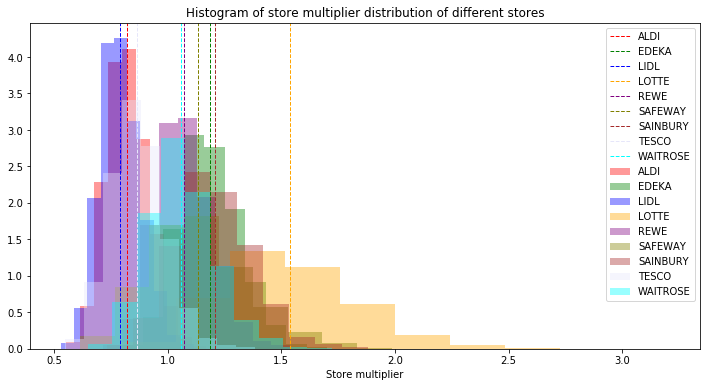

,0,1,2,3,4,5,6,7,8
index,2,0,7,8,4,5,1,6,3
Store,LIDL,ALDI,TESCO,WAITROSE,REWE,SAFEWAY,EDEKA,SAINBURY,LOTTE
Mean,0.785594,0.815003,0.858731,1.04863,1.06396,1.11783,1.17619,1.19505,1.50731
2.5% percentile,0.636068,0.657233,0.66119,0.806954,0.858872,0.764572,0.952993,0.916213,1.04513
97.5% percentile,0.978877,1.01388,1.10822,1.37543,1.32191,1.62611,1.46063,1.54528,2.17748
Standard Deviation,0.0891197,0.0920494,0.116835,0.143812,0.119276,0.217486,0.130244,0.162447,0.293957


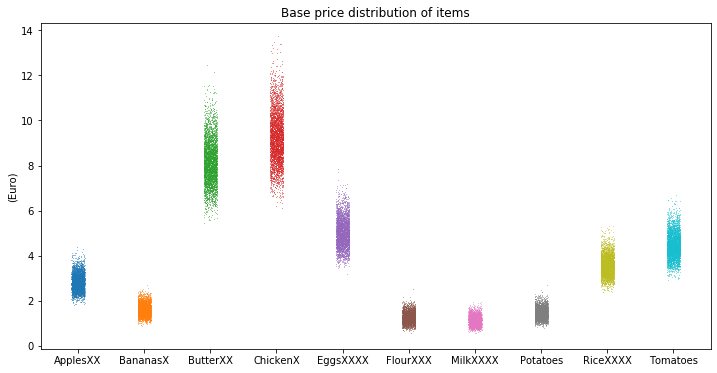

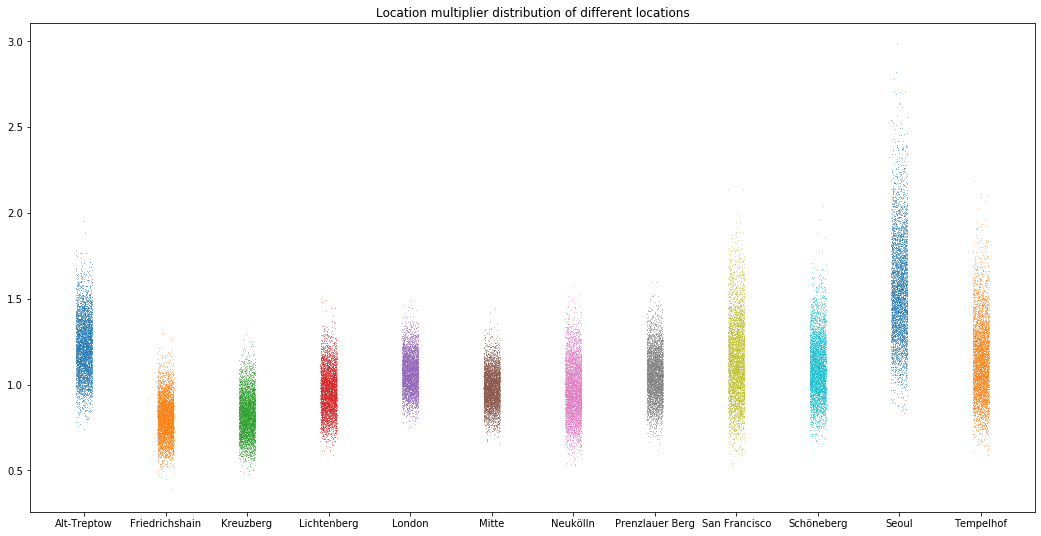

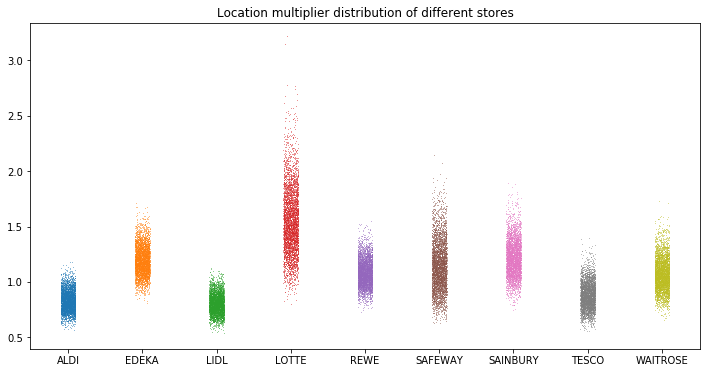

In [0]:
base_price_2, location_mul_2, store_mul_2 = visualization(b_data, posterior_samples_2)

In [0]:
stan_code_3 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_price;  
    int<lower=1> num_product;
    real<lower=0> price[num_price];  
    vector<lower=0>[num_product] product[num_price];  
    int<lower=1> num_location; 
    vector<lower=0>[num_location] location[num_price];  
    int<lower=1> num_store;
    vector<lower=0>[num_store] store[num_price];   
}

transformed data {
    real ldata[num_price];
    for (n in 1:num_price)
      ldata[n] <- log(price[n]);
}
// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    row_vector<lower=0>[num_location] p_location;
    row_vector<lower=0>[num_store] p_store;  
    vector<lower=0>[num_location] location_dep;
    row_vector<lower=0>[num_location] loc_std;
    row_vector<lower=0>[num_product] base;
    real<lower = 0> std;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    base ~ cauchy(0,1);

    std ~ cauchy(0,1);

    p_location ~ lognormal(0,0.25);

    p_store ~ lognormal(0, 0.25);

    loc_std ~ normal(0, 0.25);
    
    for(i in 1:num_price) {
        for (k in 1:num_location) {
          location_dep[k] ~ normal(location[i][k], loc_std[k]);
        }
        ldata[i] ~ normal(log((base*product[i])* (p_location*location_dep) * (p_store*store[i])) , std);
    }
}

"""
stan_model_3 = pystan.StanModel(model_code=stan_code_3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c342a8e72a8b825c2913d7822276531 NOW.


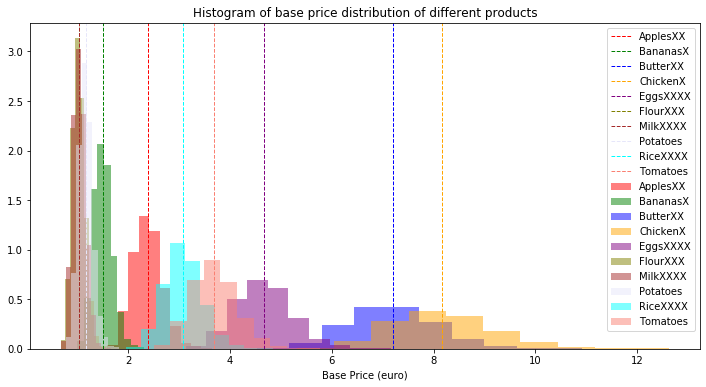

,0,1,2,3,4,5,6,7,8,9
index,5,6,7,1,0,8,9,4,2,3
Item,FlourXXX,MilkXXXX,Potatoes,BananasX,ApplesXX,RiceXXXX,Tomatoes,EggsXXXX,ButterXX,ChickenX
Mean,1.02253,1.02929,1.15488,1.49425,2.36269,3.06547,3.66133,4.65306,7.14313,8.11175
2.5% percentile,0.808474,0.812674,0.912153,1.18508,1.86989,2.42306,2.89733,3.66927,5.63504,6.40371
97.5% percentile,1.29924,1.30101,1.4658,1.89111,2.99953,3.8749,4.6472,5.90971,9.04051,10.2651
Standard Deviation,0.126089,0.126665,0.140118,0.184091,0.288418,0.375839,0.445656,0.560844,0.870269,0.995587


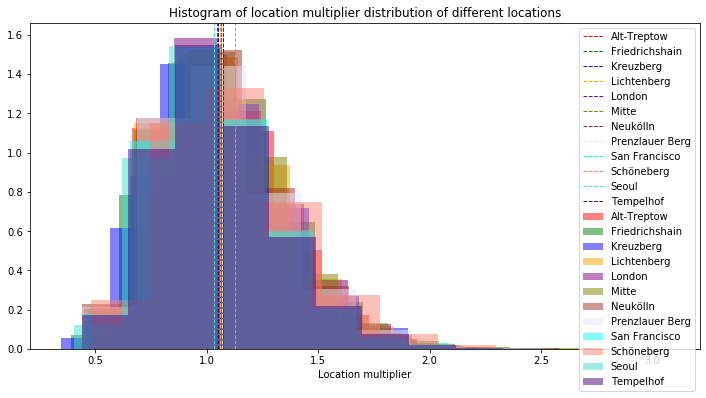

,0,1,2,3,4,5,6,7,8,9,10,11
index,10,8,11,6,0,5,3,2,4,7,1,9
Neighborhood,Seoul,San Francisco,Tempelhof,Neukölln,Alt-Treptow,Mitte,Lichtenberg,Kreuzberg,London,Prenzlauer Berg,Friedrichshain,Schöneberg
Mean,1.0033,1.01609,1.01674,1.01776,1.01991,1.02511,1.02579,1.03098,1.03551,1.03744,1.04246,1.08473
2.5% percentile,0.609879,0.629138,0.619627,0.632408,0.619815,0.633452,0.637518,0.607156,0.628092,0.624939,0.637671,0.657912
97.5% percentile,1.62065,1.66079,1.67147,1.65532,1.6505,1.70999,1.67395,1.70699,1.67613,1.71307,1.6791,1.78754
Standard Deviation,0.262042,0.266663,0.268826,0.267279,0.267525,0.274571,0.271776,0.278124,0.270349,0.277936,0.274014,0.290892


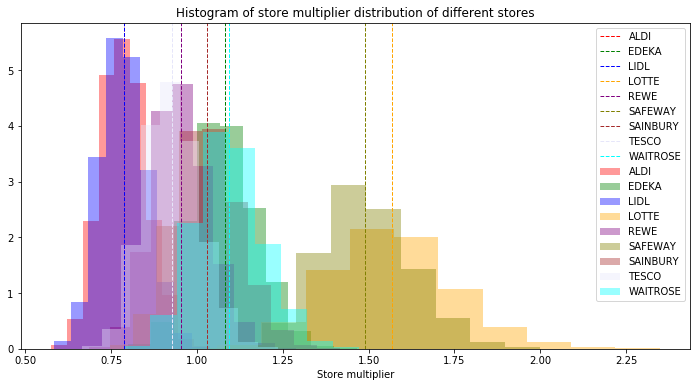

,0,1,2,3,4,5,6,7,8
index,2,0,7,4,6,1,8,5,3
Store,LIDL,ALDI,TESCO,REWE,SAINBURY,EDEKA,WAITROSE,SAFEWAY,LOTTE
Mean,0.783361,0.78358,0.922502,0.949841,1.02534,1.07747,1.08936,1.48321,1.55959
2.5% percentile,0.66461,0.66435,0.781152,0.804687,0.85771,0.916813,0.91988,1.24553,1.24715
97.5% percentile,0.92094,0.922977,1.09397,1.11992,1.21825,1.26732,1.2927,1.77355,1.9418
Standard Deviation,0.0664268,0.0669547,0.0803885,0.0811569,0.0928903,0.0909056,0.0966491,0.134489,0.176665


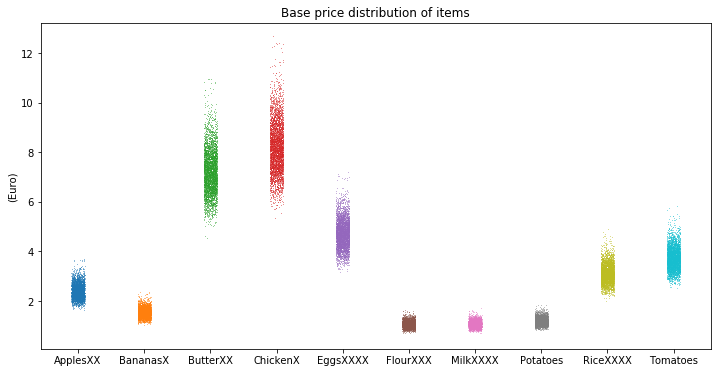

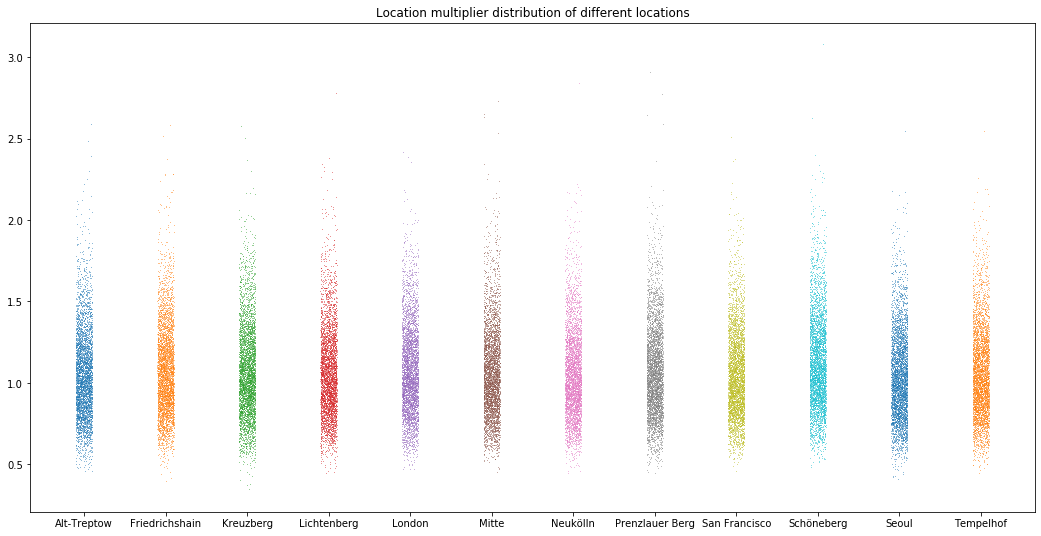

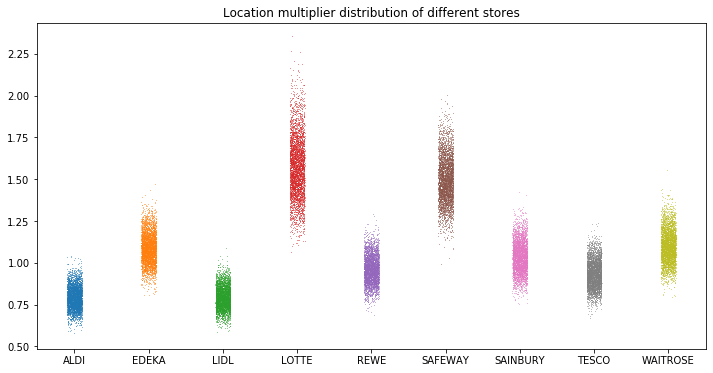

In [0]:
stan_results_3 = stan_model_3.sampling(data=stan_data_2)
posterior_samples_3 = stan_results_3.extract()

base_price_3, location_mul_3, store_mul_3 = visualization(b_data, posterior_samples_3)

1.401971380431775


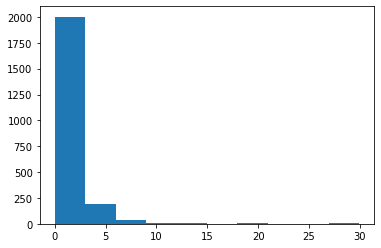

In [0]:
error = []
for i in range(len(a_data)):
  cur_store, cur_location, cur_item, cur_price = list(a_data.iloc[i])
  predict_base = float(base_price[base_price["Item"] == cur_item]["Mean"])
  predict_location_mul = float(location_mul[location_mul["Neighborhood"] == cur_location]["Mean"])
  predict_store_mul = float(store_mul[store_mul["Store"] == cur_store]["Mean"])
  predict_price = predict_base * predict_location_mul * predict_store_mul
  error.append(abs(predict_price - cur_price))

plt.hist(error)
print(np.mean(error))

1.4059708580881694


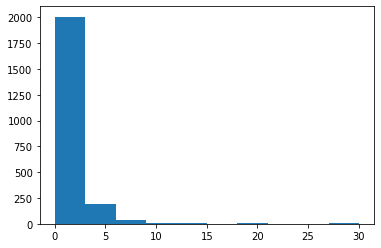

In [0]:
error_2 = []
for i in range(len(B_data)):
  cur_store, cur_location, cur_item, cur_price = list(B_data.iloc[i])
  predict_base = float(base_price_2[base_price_2["Item"] == cur_item]["Mean"])
  predict_location_mul = float(location_mul_2[location_mul_2["Neighborhood"] == cur_location]["Mean"])
  predict_store_mul = float(store_mul_2[store_mul_2["Store"] == cur_store]["Mean"])
  predict_price = predict_base * predict_location_mul * predict_store_mul
  error_2.append(abs(predict_price - cur_price))

plt.hist(error_2)
print(np.mean(error_2))

1.3736651860170883


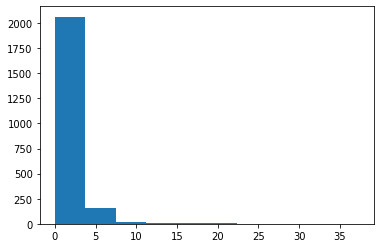

In [0]:
error_3 = []
for i in range(len(B_data)):
  cur_store, cur_location, cur_item, cur_price = list(B_data.iloc[i])
  predict_base = float(base_price_3[base_price_3["Item"] == cur_item]["Mean"])
  predict_location_mul = float(location_mul_3[location_mul_3["Neighborhood"] == cur_location]["Mean"])
  predict_store_mul = float(store_mul_3[store_mul_3["Store"] == cur_store]["Mean"])
  predict_price = predict_base * predict_location_mul * predict_store_mul
  error_3.append(abs(predict_price - cur_price))

plt.hist(error_3)
print(np.mean(error_3))

In [0]:
z_score, p_value = sts.ttest_ind(error, error_3)
1-p_value

0.3277573985052713

In [0]:
count = 0
for i in range(10000):
  a = np.random.choice(error)
  b = np.random.choice(error_3)
  if b < a:
    count += 1
print("The percentage the new model yields smaller error than the original model: ", count/10000*100, "%")

The percentage the new model yields smaller error than the original model:  52.82 %
